In [65]:
import os
from enum import Enum, auto
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, svm
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, make_scorer, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

In [66]:
class MyEnum(Enum):
    ITALIAN = auto()
    MDVR = auto()
    AH = auto()
    CZECH = auto()
    

selected_option = MyEnum.MDVR

In [67]:
final_results_df = pd.DataFrame(columns=('accuracy', 'precision', 'recall', 'f1-score'))

In [68]:
if selected_option == MyEnum.ITALIAN:
    dataset = "italian"
elif selected_option == MyEnum.MDVR:
    dataset = "mdvr"
elif selected_option == MyEnum.AH:
    dataset = "ah"
elif selected_option == MyEnum.CZECH:
    dataset = "czech"

In [69]:
#Save metrics to final table for comparison
def save_metrics_finalDf(name, y_test, y_predict):
    final_accuracy = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['accuracy'],2)
    final_precision = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['precision'],2)
    final_recall = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['recall'],2)
    final_f1score = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['f1-score'],2)
    final_results_df.loc[name] = [final_accuracy, final_precision, final_recall, final_f1score]

#Save model to a file
def save_model(model, model_name):
    
    
    dir = os.path.join("../data/models", dataset, "interpretable")
    Path(dir).mkdir(parents=True, exist_ok=True)

    model_filename = os.path.join(dir , model_name + '.joblib')
    joblib.dump(model, model_filename)



# Model Building

In [70]:

path_to_features = os.path.join("../data/tables/", dataset + "_features.csv")
path_to_reduced_features = os.path.join("../data/tables/", dataset + "_reduced_features.csv")

#load tables from processing
features_df = pd.read_csv(path_to_features)
reduced_features_df = pd.read_csv(path_to_reduced_features)


In [71]:
features_df

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer,PD
0,114.559712,11.523052,14.191471,0.028422,0.000201,0.013405,0.013165,0.040214,0.118961,1.146972,0.038164,0.066994,0.123395,0.114493,1.0
1,238.138062,18.861410,17.299559,0.011556,0.000047,0.004619,0.005859,0.013858,0.053902,0.492988,0.021755,0.031201,0.069907,0.065264,1.0
2,223.685833,44.077130,15.327212,0.020620,0.000093,0.009925,0.007579,0.029775,0.063626,0.763410,0.025858,0.028366,0.040768,0.077573,1.0
3,132.029628,12.062114,12.557775,0.017816,0.000135,0.007793,0.008405,0.023378,0.083822,0.738992,0.030570,0.050306,0.094678,0.091711,1.0
4,175.314689,15.264781,13.798862,0.013002,0.000074,0.005781,0.007909,0.017344,0.104535,1.010369,0.036758,0.062875,0.123395,0.110275,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,193.209988,22.001734,13.987776,0.016422,0.000085,0.007082,0.009177,0.021245,0.086505,0.940830,0.033335,0.049701,0.091187,0.100005,0.0
1580,117.653228,8.975167,12.096987,0.023460,0.000199,0.009138,0.011369,0.027414,0.093464,0.816516,0.031271,0.048431,0.106553,0.093812,0.0
1581,209.829420,44.077130,7.536627,0.027930,0.000133,0.012246,0.014303,0.036737,0.112934,1.146972,0.041220,0.058284,0.105104,0.123659,0.0
1582,153.326690,19.930532,12.334277,0.030184,0.000201,0.013405,0.014728,0.040214,0.076875,0.762129,0.023152,0.036592,0.071444,0.069456,0.0


In [72]:

reduced_features_df

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer,PD
0,114.559712,11.523052,14.191471,0.028422,0.000201,0.013405,0.013165,0.040214,0.118961,1.146972,0.038164,0.066994,0.123395,0.114493,1.0
1,238.138062,18.861410,17.299559,0.011556,0.000047,0.004619,0.005859,0.013858,0.053902,0.492988,0.021755,0.031201,0.069907,0.065264,1.0
2,223.685833,44.077130,15.327212,0.020620,0.000093,0.009925,0.007579,0.029775,0.063626,0.763410,0.025858,0.028366,0.040768,0.077573,1.0
3,132.029628,12.062114,12.557775,0.017816,0.000135,0.007793,0.008405,0.023378,0.083822,0.738992,0.030570,0.050306,0.094678,0.091711,1.0
4,175.314689,15.264781,13.798862,0.013002,0.000074,0.005781,0.007909,0.017344,0.104535,1.010369,0.036758,0.062875,0.123395,0.110275,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,193.209988,22.001734,13.987776,0.016422,0.000085,0.007082,0.009177,0.021245,0.086505,0.940830,0.033335,0.049701,0.091187,0.100005,0.0
1580,117.653228,8.975167,12.096987,0.023460,0.000199,0.009138,0.011369,0.027414,0.093464,0.816516,0.031271,0.048431,0.106553,0.093812,0.0
1581,209.829420,44.077130,7.536627,0.027930,0.000133,0.012246,0.014303,0.036737,0.112934,1.146972,0.041220,0.058284,0.105104,0.123659,0.0
1582,153.326690,19.930532,12.334277,0.030184,0.000201,0.013405,0.014728,0.040214,0.076875,0.762129,0.023152,0.036592,0.071444,0.069456,0.0


In [73]:
# lets build our classification model
# independent variables
X = reduced_features_df.drop(["PD"], axis=1)

# the dependent variable
y = reduced_features_df['PD']



In [74]:
X

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer
0,114.559712,11.523052,14.191471,0.028422,0.000201,0.013405,0.013165,0.040214,0.118961,1.146972,0.038164,0.066994,0.123395,0.114493
1,238.138062,18.861410,17.299559,0.011556,0.000047,0.004619,0.005859,0.013858,0.053902,0.492988,0.021755,0.031201,0.069907,0.065264
2,223.685833,44.077130,15.327212,0.020620,0.000093,0.009925,0.007579,0.029775,0.063626,0.763410,0.025858,0.028366,0.040768,0.077573
3,132.029628,12.062114,12.557775,0.017816,0.000135,0.007793,0.008405,0.023378,0.083822,0.738992,0.030570,0.050306,0.094678,0.091711
4,175.314689,15.264781,13.798862,0.013002,0.000074,0.005781,0.007909,0.017344,0.104535,1.010369,0.036758,0.062875,0.123395,0.110275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,193.209988,22.001734,13.987776,0.016422,0.000085,0.007082,0.009177,0.021245,0.086505,0.940830,0.033335,0.049701,0.091187,0.100005
1580,117.653228,8.975167,12.096987,0.023460,0.000199,0.009138,0.011369,0.027414,0.093464,0.816516,0.031271,0.048431,0.106553,0.093812
1581,209.829420,44.077130,7.536627,0.027930,0.000133,0.012246,0.014303,0.036737,0.112934,1.146972,0.041220,0.058284,0.105104,0.123659
1582,153.326690,19.930532,12.334277,0.030184,0.000201,0.013405,0.014728,0.040214,0.076875,0.762129,0.023152,0.036592,0.071444,0.069456


In [75]:
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1579    0.0
1580    0.0
1581    0.0
1582    0.0
1583    0.0
Name: PD, Length: 1584, dtype: float64

In [76]:

# path to save model

dir = "../data/models/" + dataset + "/interpretable/"
features_names_path = dir + 'features_names' + '.joblib'


In [77]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [78]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(reduced_features_df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(reduced_features_df.index)) * 100))

69.95% data is in training set
30.05% data is in test set


In [79]:
y_train_yPD=y_train[y_train==1].count()
y_train_nPD=y_train[y_train==0].count()
y_test_yPD=y_test[y_test==1].count()
y_test_nPD=y_test[y_test==0].count()

print("In the original dataset people who had parkinson Dieases    : {0} ({1:0.2f}%)".format(len(reduced_features_df.loc[features_df['PD'] == 1]), (len(reduced_features_df.loc[features_df['PD'] == 1])/len(reduced_features_df.index)) * 100))
print("In the original dataset people who didnot have Parkinson Disease   : {0} ({1:0.2f}%)".format(len(reduced_features_df.loc[features_df['PD'] == 0]), (len(reduced_features_df.loc[features_df['PD'] == 0])/len(reduced_features_df.index)) * 100))
print("")
print("In the training dataset people who who had parkinson Dieases    : {0} ({1:0.2f}%)".format(y_train_yPD, (y_train_yPD/len(y_train))*100))
print("In the training dataset people who didnot have Parkinson Disease    : {0} ({1:0.2f}%)".format(y_train_nPD, (y_train_nPD/len(y_train))*100))
print("")
print("In the test dataset people who who had parkinson Dieases    : {0} ({1:0.2f}%)".format(y_test_yPD, (y_test_yPD/len(y_test))*100))
print("In the test dataset people who didnot have Parkinson Disease    : {0} ({1:0.2f}%)".format(y_test_nPD, (y_test_nPD/len(y_test))*100))

In the original dataset people who had parkinson Dieases    : 669 (42.23%)
In the original dataset people who didnot have Parkinson Disease   : 915 (57.77%)

In the training dataset people who who had parkinson Dieases    : 460 (41.52%)
In the training dataset people who didnot have Parkinson Disease    : 648 (58.48%)

In the test dataset people who who had parkinson Dieases    : 209 (43.91%)
In the test dataset people who didnot have Parkinson Disease    : 267 (56.09%)


scScales impact

Gradient descent based algorithms like Linear Regression, Logistics Regression
Distance based algorithms like KNN, K-means and SVM
Scales dont impact:

Tree based algorithms like Decision trees

In [80]:
# Scale
sc = MinMaxScaler()



X_train = pd.DataFrame(sc.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(sc.transform(X_test.values), columns=X_test.columns, index=X_test.index)



if not os.path.exists(dir):
    os.makedirs(dir, exist_ok=True)

# save scale to apply same scaling in future test data
scaler_path = dir + 'scaler' + '.save'
features_names_path = dir + 'features_names' + '.joblib'

joblib.dump(sc, scaler_path)
joblib.dump(X_train.columns, features_names_path)

pd.DataFrame(X_train)

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer
866,0.729008,0.638977,0.495301,0.748962,0.549548,0.595798,0.524196,0.595798,0.810531,0.793297,0.545579,0.665862,0.613036,0.545579
1569,0.951072,0.659321,0.807970,0.485580,0.289937,0.547656,0.448323,0.547656,0.267476,0.299989,0.283720,0.227521,0.250677,0.283720
943,0.921412,1.000000,0.521039,1.000000,0.668458,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992777,1.000000
593,0.288910,0.336576,0.456501,0.605295,0.704897,0.518003,0.558815,0.518003,0.679906,0.687987,0.608859,0.582343,0.502985,0.608859
1348,0.357117,0.746510,0.422279,0.874314,0.928329,0.687292,0.868274,0.687292,1.000000,1.000000,1.000000,1.000000,0.984943,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.716845,0.537904,0.597736,0.560672,0.416386,0.579300,0.609922,0.579300,0.605778,0.625162,0.410812,0.461149,0.618835,0.410812
905,0.589801,0.338603,0.550303,0.732086,0.610430,0.436853,0.595990,0.436853,0.515009,0.504902,0.336601,0.505760,0.589838,0.336601
1096,0.760679,0.745762,0.687700,0.813153,0.569452,0.970904,0.849006,0.970904,0.883639,0.957133,0.939951,0.926270,0.694566,0.939951
235,0.193394,0.400549,0.484131,0.736810,0.960594,0.704860,0.810169,0.704860,0.880059,0.938862,1.000000,1.000000,0.798602,1.000000


In [81]:
if (pd.DataFrame(X_train).isnull().sum().any()==0):
    print('There are no null values in the training datset')
else:
    print('There are null values in the training datset')

if (pd.DataFrame(X_test).isnull().sum().any()==0):
    print('There are no null values in the test datset')
else:
    print('There are null values in the test datset')

There are no null values in the training datset
There are no null values in the test datset


In [82]:
#show table of (predicted - proba - actual) values
def predicted_vs_actual_table(model, X_test, y_test, model_type = None):
    # Predict probabilities on the test data
    y_predict_proba = model.predict_proba(X_test)

    # Assuming you are interested in the probability of the positive class (class 1)
    positive_class_prob = y_predict_proba[:, 1]

    # Create a DataFrame to compare each individual predicted probability to the real value
    comparison_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted_Probability': positive_class_prob,
        'Predicted_Class': model.predict(X_test)
    })
    if model_type == None:
        comparison_df.Name = type(model).__name__
    else:
        comparison_df.Name = model_type.__name__

    # Print or use the DataFrame as needed
    pd.set_option('display.max_rows', 50)
    return comparison_df




def predicted_vs_actual_plot(comparison_df):

    # Sort the DataFrame by the 'Actual' column
    model_name = comparison_df.Name
    sorted_df = comparison_df.sort_values(by='Actual')

    # Scatter plot of Actual vs Predicted Probability
    plt.figure(figsize=(10, 7))
    plt.scatter(range(len(sorted_df)), sorted_df['Actual'], label='Actual', color='blue', alpha=0.7)
    plt.scatter(range(len(sorted_df)), sorted_df['Predicted_Probability'], label='Predicted Probability', color='red', alpha=0.7)

    # Draw a horizontal line at y=0.5 for separation
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

    plt.xlabel('Data Point (Index)')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted Probability ' + model_name)
    plt.legend()
    plt.show()

# Logistic Regression with Hyperparameter tuning

In [83]:
# List Hyperparameters that we want to tune.


solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Convert to dictionary
hyperparameters = dict(solver=solvers, penalty=penalty, C=c_values)

# Create new LR object
model_lr_2 = LogisticRegression(max_iter=1000)

# Create RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform k-fold cross-validation
cv_results = cross_val_score(model_lr_2, X_train, y_train, cv=cv, scoring='accuracy')

# Print the results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Use GridSearch
clf = GridSearchCV(model_lr_2, hyperparameters, cv=cv)

# Fit the model
best_model_lr_2 = clf.fit(X_train, y_train)

# Print the value of best hyperparameters
print('Best Score: %s' % best_model_lr_2.best_score_)
print('Best Hyperparameters: %s' % best_model_lr_2.best_params_)

y_pred_lr_2 = best_model_lr_2.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_lr_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0, 0] + conf_matrix_knn_2[1, 1]) / (conf_matrix_knn_2[0, 0] + conf_matrix_knn_2[0, 1] + conf_matrix_knn_2[1, 0] + conf_matrix_knn_2[1, 1])) * 100

Cross-Validation Accuracy: 75.541% (± 2.652%)


Best Score: 0.7563144963144963
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [84]:
pd.set_option('display.max_rows', None)
table_lr_2 = predicted_vs_actual_table(best_model_lr_2, X_test, y_test, type(model_lr_2))


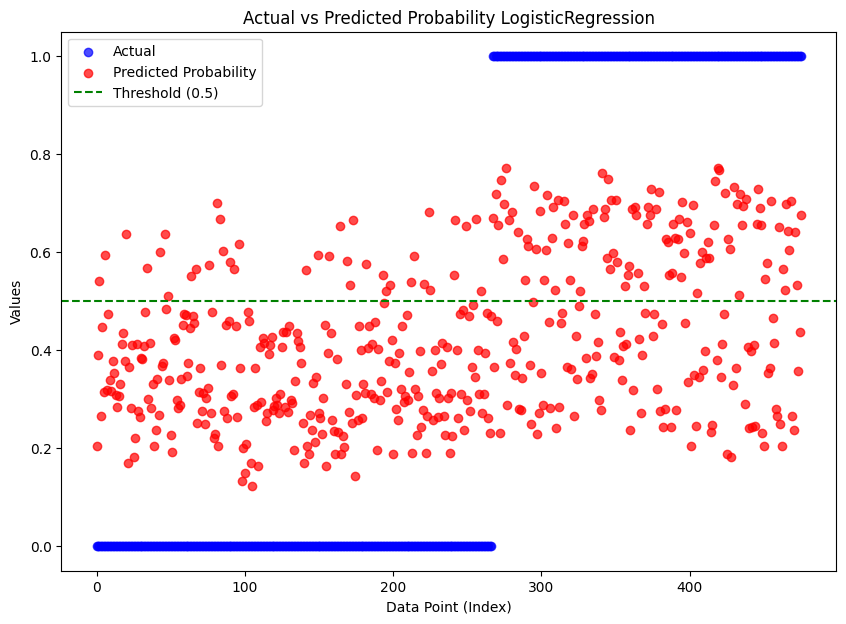

In [85]:
pva_plot_lr_2 = predicted_vs_actual_plot(table_lr_2)

              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77       267
         1.0       0.75      0.53      0.62       209

    accuracy                           0.71       476
   macro avg       0.72      0.69      0.69       476
weighted avg       0.72      0.71      0.70       476



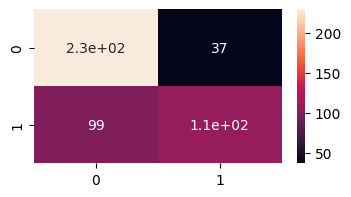

In [86]:

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)


#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_lr_2))
#Checking performance our model with ROC Score.

save_metrics_finalDf('Logistic Regression (HPT)', y_test, y_pred_lr_2)
save_model(best_model_lr_2, 'lr_2')

# KNN with hyperparameter tuning

In [87]:
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 20)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Create a KNeighborsClassifier
model_knn_2 = KNeighborsClassifier()

# Create GridSearchCV
clf = GridSearchCV(model_knn_2, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
clf.fit(X_train, np.ravel(y_train, order='C'))

# Get the best parameters
best_params = clf.best_params_

# Get the best model
best_model_knn_2 = clf.best_estimator_

# Evaluate the best model using k-fold cross-validation
cv_results = cross_val_score(best_model_knn_2, X_train, np.ravel(y_train, order='C'), cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Evaluate the best model on the test set
y_pred_knn_2 = best_model_knn_2.predict(X_test)
model_score_knn = best_model_knn_2.score(X_test, y_test)

# Print the results
print('Best Hyperparameters:', best_params)
print('Best Model Score:', model_score_knn)

Cross-Validation Accuracy: 89.439% (± 3.149%)
Best Hyperparameters: {'n_neighbors': 12, 'p': 2, 'weights': 'distance'}
Best Model Score: 0.907563025210084


In [88]:
table_knn_2 = predicted_vs_actual_table(best_model_knn_2, X_test, y_test, type(model_knn_2))
print(table_knn_2)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.000000              0.0
654      1.0               1.000000              1.0
572      1.0               1.000000              1.0
1132     0.0               0.168439              0.0
628      1.0               1.000000              1.0
...      ...                    ...              ...
581      1.0               1.000000              1.0
126      1.0               1.000000              1.0
478      1.0               1.000000              1.0
985      0.0               0.000000              0.0
589      1.0               1.000000              1.0

[476 rows x 3 columns]


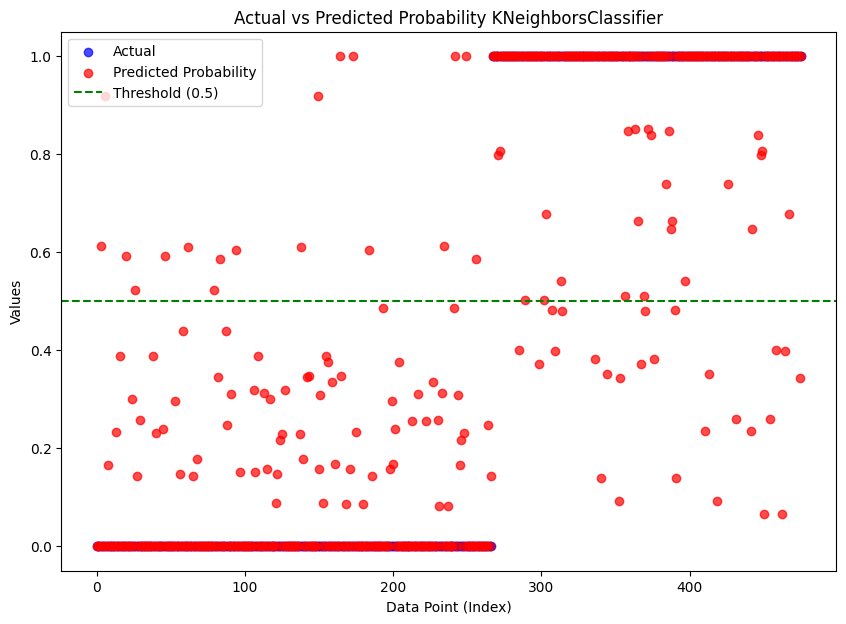

In [89]:
predicted_vs_actual_plot(table_knn_2)

90.75630252100841
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       267
         1.0       0.91      0.88      0.89       209

    accuracy                           0.91       476
   macro avg       0.91      0.90      0.91       476
weighted avg       0.91      0.91      0.91       476



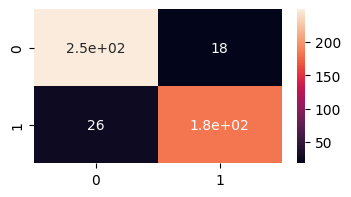

In [90]:

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)

save_metrics_finalDf('KNN (HPT)', y_test, y_pred_knn_2)
save_model(best_model_knn_2, 'knn_2')

# Naive Bayes

### No important parameters to tune

In [91]:
model_nb = GaussianNB()

# Perform k-fold cross-validation
cv_results = cross_val_score(model_nb, X_train, np.ravel(y_train, order='C'), cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Fit the model to the training data
model_nb.fit(X_train, np.ravel(y_train, order='C'))

# Make predictions on the test set
y_predict_nb = model_nb.predict(X_test)

# Evaluate the model on the test set
model_score_nb = metrics.accuracy_score(y_test, y_predict_nb)

# Print the results
print('Model Score:', model_score_nb)

Cross-Validation Accuracy: 63.443% (± 4.075%)
Model Score: 0.6176470588235294


In [92]:
table_nb = predicted_vs_actual_table(model_nb, X_test, y_test)
table_nb.Name = type(GaussianNB()).__name__
print(table_nb)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.076122              0.0
654      1.0               0.154528              0.0
572      1.0               0.289304              0.0
1132     0.0               0.290695              0.0
628      1.0               0.357136              0.0
...      ...                    ...              ...
581      1.0               0.626077              1.0
126      1.0               0.957702              1.0
478      1.0               0.069864              0.0
985      0.0               0.069919              0.0
589      1.0               0.996151              1.0

[476 rows x 3 columns]


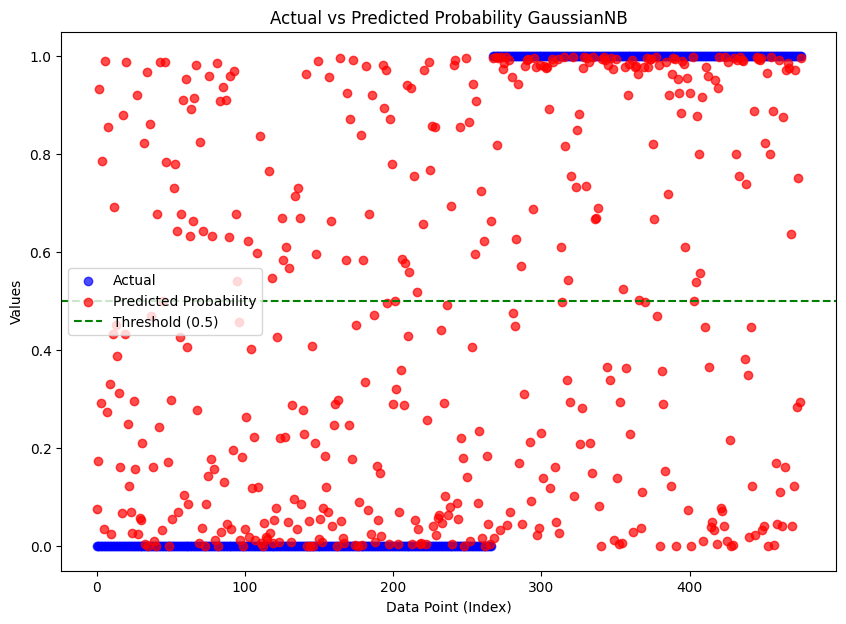

In [93]:
predicted_vs_actual_plot(table_nb)

Confusion Matrix - Naive Bayes
Classification Report - Naive Bayes
              precision    recall  f1-score   support

           1       0.56      0.60      0.58       209
           0       0.67      0.63      0.65       267

    accuracy                           0.62       476
   macro avg       0.61      0.62      0.61       476
weighted avg       0.62      0.62      0.62       476



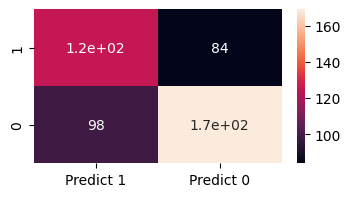

In [94]:
print("Confusion Matrix - Naive Bayes")
cm=metrics.confusion_matrix(y_test, y_predict_nb, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - Naive Bayes")
print(metrics.classification_report(y_test, y_predict_nb, labels=[1, 0]))

save_metrics_finalDf('NB', y_test, y_predict_nb)
save_model(model_nb, 'nb')

# SVM with hyperparameter tuning

In [95]:
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

# Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)

# Create new SVM object
model_svm_2 = svm.SVC(probability=True)

# Create RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Use GridSearchCV
clf = GridSearchCV(model_svm_2, hyperparameters, refit=True, cv=cv)

# Fit the model
best_model_svm_2 = clf.fit(X_train, y_train)

# Print the value of best hyperparameters
print('Best Score: %s' % best_model_svm_2.best_score_)
print('Best Hyperparameters: %s' % best_model_svm_2.best_params_)
print(hyperparameters)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(best_model_svm_2.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Make predictions on the test set
y_pred_svm_2 = best_model_svm_2.predict(X_test)

# Evaluate the model on the test set
conf_matrix_svm_2 = confusion_matrix(y_test, y_pred_svm_2)
accuracy_svm_2 = ((conf_matrix_svm_2[0,0] + conf_matrix_svm_2[1,1]) / (conf_matrix_svm_2[0,0] + conf_matrix_svm_2[0,1] + conf_matrix_svm_2[1,0] + conf_matrix_svm_2[1,1])) * 100

# Print the results
print('Model Score:', accuracy_svm_2)

Best Score: 0.894998634998635
Best Hyperparameters: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
Cross-Validation Accuracy: 89.500% (± 2.886%)
Model Score: 89.91596638655463


In [96]:
table_svm_2 = predicted_vs_actual_table(best_model_lr_2, X_test, y_test, type(model_svm_2))
print(table_svm_2)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.204346              0.0
654      1.0               0.280608              0.0
572      1.0               0.242972              0.0
1132     0.0               0.188034              0.0
628      1.0               0.452516              0.0
...      ...                    ...              ...
581      1.0               0.402860              0.0
126      1.0               0.681705              1.0
478      1.0               0.372994              0.0
985      0.0               0.281349              0.0
589      1.0               0.676729              1.0

[476 rows x 3 columns]


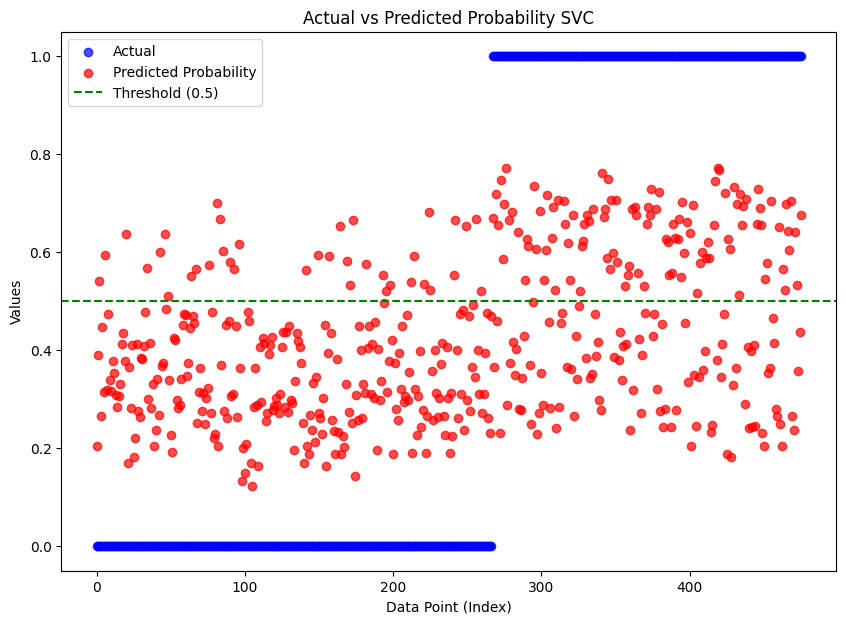

In [97]:
predicted_vs_actual_plot(table_svm_2)

              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       267
         1.0       0.86      0.91      0.89       209

    accuracy                           0.90       476
   macro avg       0.90      0.90      0.90       476
weighted avg       0.90      0.90      0.90       476



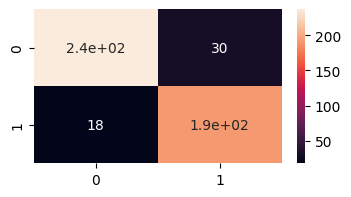

In [98]:
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_svm_2))
#Checking performance our model with ROC Score.


plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_svm_2, annot=True)

save_metrics_finalDf('SVM (HPT)', y_test, y_pred_svm_2)
save_model(best_model_svm_2, 'svm_2')

# Random Forest with Hyperparameter Tuning

In [99]:
# Define the RandomForestClassifier with default parameters
model_rf = RandomForestClassifier(random_state=1)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees in the forest
    'max_features': [3, 5, 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
}

# Create GridSearchCV
grid_search_rf = GridSearchCV(model_rf, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_

# Print the best parameters
print("Best Hyperparameters for Random Forest:", best_params_rf)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Use the best model for predictions
best_model_rf = grid_search_rf.best_estimator_
y_predict_rf = best_model_rf.predict(X_test)

Best Hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
Cross-Validation Accuracy: 91.154% (± 1.776%)


In [100]:
table_rf = predicted_vs_actual_table(best_model_rf, X_test, y_test)
print(table_rf)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.166998              0.0
654      1.0               0.665169              1.0
572      1.0               0.373933              0.0
1132     0.0               0.107936              0.0
628      1.0               0.792301              1.0
...      ...                    ...              ...
581      1.0               0.884878              1.0
126      1.0               0.976234              1.0
478      1.0               0.820004              1.0
985      0.0               0.122283              0.0
589      1.0               0.940000              1.0

[476 rows x 3 columns]


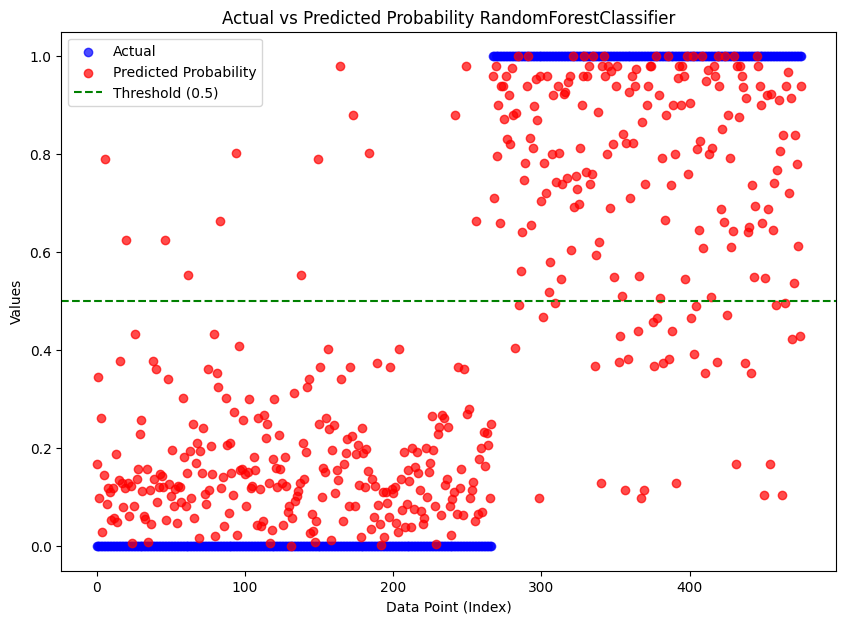

In [101]:
predicted_vs_actual_plot(table_rf)

Confusion Matrix -Random Forest


<Axes: >

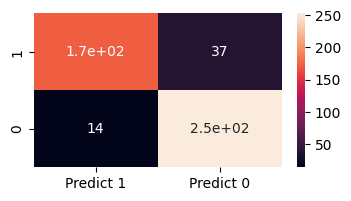

In [102]:
print("Confusion Matrix -Random Forest")
cm=metrics.confusion_matrix(y_test, y_predict_rf, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [103]:
print("Classification Report - Random Forest")
print(metrics.classification_report(y_test, y_predict_rf, labels=[1, 0]))

Classification Report - Random Forest
              precision    recall  f1-score   support

           1       0.92      0.82      0.87       209
           0       0.87      0.95      0.91       267

    accuracy                           0.89       476
   macro avg       0.90      0.89      0.89       476
weighted avg       0.90      0.89      0.89       476



In [104]:
# Save metrics and model
save_metrics_finalDf('Random Forest (HPT)', y_test, y_predict_rf)
save_model(best_model_rf, 'rf_2')

# Bagging with Hyperparameter Tuning

In [105]:
model_bgcl_2 = BaggingClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Create GridSearchCV
grid_search_bgcl = GridSearchCV(model_bgcl_2, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_bgcl.fit(X_train, y_train)

# Get the best hyperparameters
best_params_bgcl = grid_search_bgcl.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for Bagging Classifier:", best_params_bgcl)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_bgcl.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Get the best Bagging Classifier model
best_model_bgcl_2 = grid_search_bgcl.best_estimator_

# Fit the best model on the training data
best_model_bgcl_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_bag_2 = best_model_bgcl_2.predict(X_test)

Best Hyperparameters for Bagging Classifier: {'n_estimators': 30}
Cross-Validation Accuracy: 90.885% (± 1.982%)


In [106]:
table_bgcl_2 = predicted_vs_actual_table(best_model_bgcl_2, X_test, y_test, type(model_bgcl_2))
print(table_bgcl_2)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.233333              0.0
654      1.0               0.766667              1.0
572      1.0               0.633333              1.0
1132     0.0               0.066667              0.0
628      1.0               0.900000              1.0
...      ...                    ...              ...
581      1.0               0.966667              1.0
126      1.0               1.000000              1.0
478      1.0               0.800000              1.0
985      0.0               0.166667              0.0
589      1.0               1.000000              1.0

[476 rows x 3 columns]


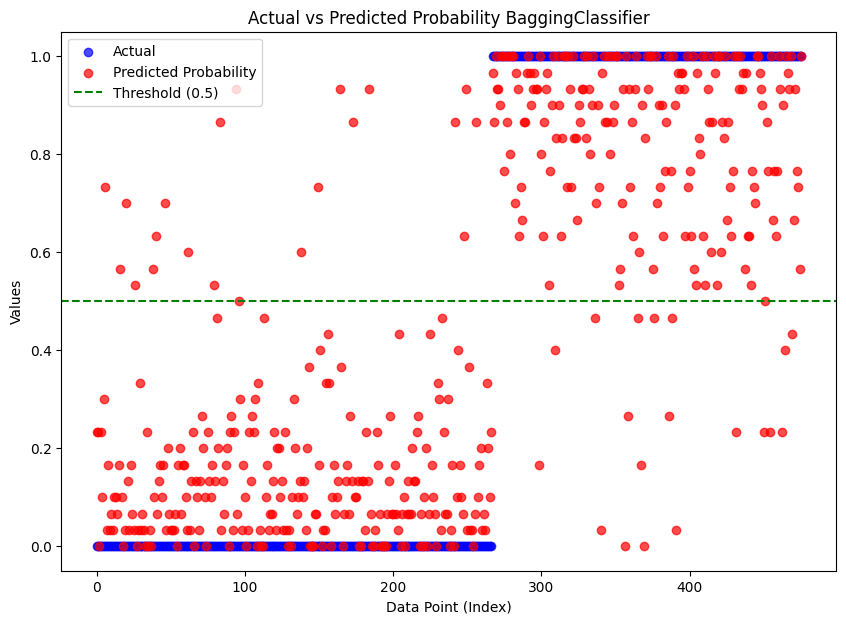

In [107]:
predicted_vs_actual_plot(table_bgcl_2)

Confusion Matrix - Bagging Classifier
Classification Report - Bagging Classifier
              precision    recall  f1-score   support

           1       0.90      0.90      0.90       209
           0       0.93      0.93      0.93       267

    accuracy                           0.92       476
   macro avg       0.91      0.91      0.91       476
weighted avg       0.92      0.92      0.92       476



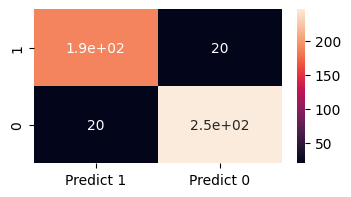

In [108]:

# Compute and print the confusion matrix
print("Confusion Matrix - Bagging Classifier")
cm = confusion_matrix(y_test, y_predict_bag_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Bagging Classifier")
print(classification_report(y_test, y_predict_bag_2, labels=[1, 0]))

save_metrics_finalDf('Bagging (HPT)', y_test, y_predict_bag_2)
save_model(best_model_bgcl_2, 'bgcl_2')


# AdaBoost with Hyperparameter Tuning

In [109]:
model_adabc_2 = AdaBoostClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Create GridSearchCV
grid_search_adabc = GridSearchCV(model_adabc_2, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_adabc.fit(X_train, y_train)

# Get the best hyperparameters
best_params_adabc = grid_search_adabc.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for AdaBoost Classifier:", best_params_adabc)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_adabc.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Get the best AdaBoost Classifier model
best_model_adabc_2 = grid_search_adabc.best_estimator_

# Fit the best model on the training data
best_model_adabc_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_ada_2 = best_model_adabc_2.predict(X_test)

Best Hyperparameters for AdaBoost Classifier: {'n_estimators': 30}
Cross-Validation Accuracy: 78.876% (± 4.526%)


In [110]:
table_adabc_2 = predicted_vs_actual_table(best_model_adabc_2, X_test, y_test, type(model_adabc_2))
print(table_adabc_2)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.496736              0.0
654      1.0               0.502156              1.0
572      1.0               0.484778              0.0
1132     0.0               0.471422              0.0
628      1.0               0.510286              1.0
...      ...                    ...              ...
581      1.0               0.503439              1.0
126      1.0               0.562695              1.0
478      1.0               0.510852              1.0
985      0.0               0.485345              0.0
589      1.0               0.554953              1.0

[476 rows x 3 columns]


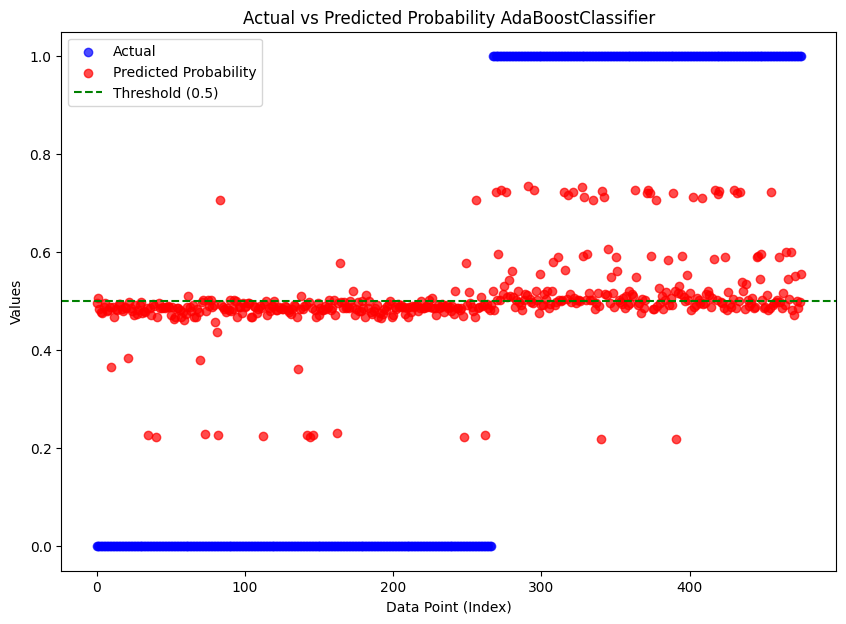

In [111]:
predicted_vs_actual_plot(table_adabc_2)

Confusion Matrix - Ada Boost
Classification Report - Ada Boost
              precision    recall  f1-score   support

           1       0.84      0.66      0.74       209
           0       0.77      0.90      0.83       267

    accuracy                           0.79       476
   macro avg       0.81      0.78      0.78       476
weighted avg       0.80      0.79      0.79       476



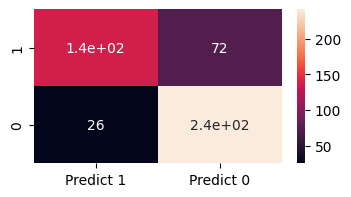

In [112]:

# Compute and print the confusion matrix
print("Confusion Matrix - Ada Boost")
cm = confusion_matrix(y_test, y_predict_ada_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Ada Boost")
print(classification_report(y_test, y_predict_ada_2, labels=[1, 0]))

save_metrics_finalDf('AdaBoost (HPT)', y_test, y_predict_ada_2)
save_model(best_model_adabc_2, 'adabc_2')


# XGBoost with Hyperparameter tuning

In [113]:
model_xgbc_2 = XGBClassifier(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate
    'n_estimators': [50, 100, 200],  # Adjust the number of estimators
    'max_depth': [3, 4, 5]  # Adjust the maximum depth of trees
    # You can add more hyperparameters to tune here
}

# Create GridSearchCV
grid_search_xgbc = GridSearchCV(model_xgbc_2, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_xgbc.fit(X_train, y_train)

# Get the best hyperparameters
best_params_xgbc = grid_search_xgbc.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for XGBClassifier:", best_params_xgbc)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_xgbc.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Get the best XGBClassifier model
best_model_xgbc_2 = grid_search_xgbc.best_estimator_

# Fit the best model on the training data
best_model_xgbc_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_XGB_2 = best_model_xgbc_2.predict(X_test)

Best Hyperparameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Cross-Validation Accuracy: 90.249% (± 2.830%)


In [114]:
table_xgbc_2 = predicted_vs_actual_table(best_model_xgbc_2, X_test, y_test)
print(table_xgbc_2)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.052762                0
654      1.0               0.938530                1
572      1.0               0.826747                1
1132     0.0               0.101323                0
628      1.0               0.904062                1
...      ...                    ...              ...
581      1.0               0.980378                1
126      1.0               0.998912                1
478      1.0               0.967170                1
985      0.0               0.111823                0
589      1.0               0.998968                1

[476 rows x 3 columns]


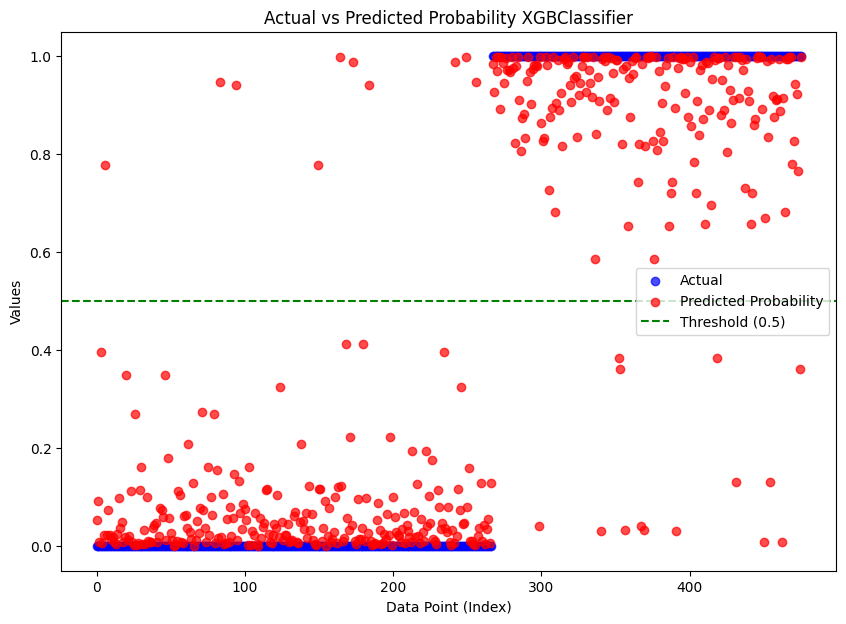

In [115]:
predicted_vs_actual_plot(table_xgbc_2)

Confusion Matrix - XGB Classifier
Classification Report - XGB Classifier
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       209
           0       0.95      0.96      0.96       267

    accuracy                           0.95       476
   macro avg       0.95      0.95      0.95       476
weighted avg       0.95      0.95      0.95       476



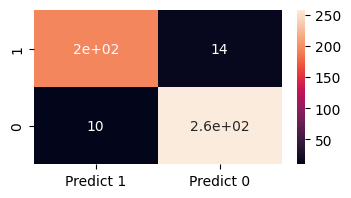

In [116]:
# Compute and print the confusion matrix
print("Confusion Matrix - XGB Classifier")
cm = confusion_matrix(y_test, y_predict_XGB_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4,2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - XGB Classifier")
print(classification_report(y_test, y_predict_XGB_2, labels=[1, 0]))


save_metrics_finalDf('XGBoost (HPT)', y_test, y_predict_XGB_2)
save_model(best_model_xgbc_2, 'xgbc_2')


# Neural Network

In [117]:
model_nn = MLPClassifier(random_state=0)

# Define the hyperparameters grid to search
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Adjust the size of hidden layers
    'activation': ['relu', 'tanh'],  # Adjust the activation function
    'solver': ['adam', 'sgd'],  # Adjust the solver algorithm
    'learning_rate_init': [0.001, 0.01, 0.1],  # Adjust the initial learning rate
    # You can add more hyperparameters to tune here
}

# Create GridSearchCV
grid_search_nn = GridSearchCV(model_nn, param_grid_nn, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_nn.fit(X_train, y_train)

# Get the best hyperparameters
best_params_nn = grid_search_nn.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for MLPClassifier:", best_params_nn)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_nn.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Get the best MLPClassifier model
best_model_nn = grid_search_nn.best_estimator_

# Fit the best model on the training data
best_model_nn.fit(X_train, y_train)

# Make predictions on the test set
y_predict_nn = best_model_nn.predict(X_test)

/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarn

Best Hyperparameters for MLPClassifier: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarn

Cross-Validation Accuracy: 82.582% (± 2.838%)


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [118]:
table_nn = predicted_vs_actual_table(best_model_nn, X_test, y_test)
print(table_nn)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.182247              0.0
654      1.0               0.568126              1.0
572      1.0               0.420605              0.0
1132     0.0               0.324666              0.0
628      1.0               0.458511              0.0
...      ...                    ...              ...
581      1.0               0.880517              1.0
126      1.0               0.998740              1.0
478      1.0               0.581830              1.0
985      0.0               0.008457              0.0
589      1.0               0.855376              1.0

[476 rows x 3 columns]


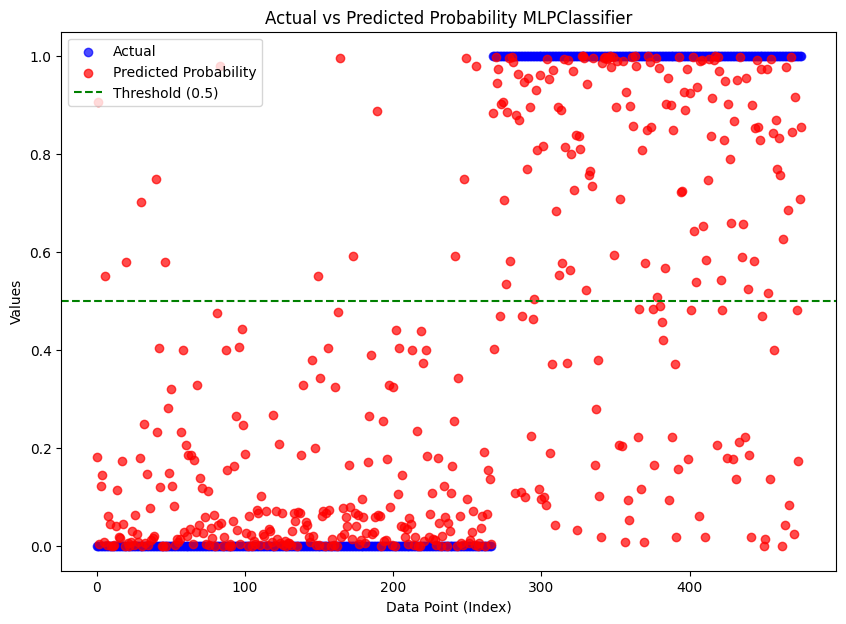

In [119]:
predicted_vs_actual_plot(table_nn)

Confusion Matrix - XGB Classifier
Classification Report - XGB Classifier
              precision    recall  f1-score   support

           1       0.91      0.69      0.78       209
           0       0.79      0.94      0.86       267

    accuracy                           0.83       476
   macro avg       0.85      0.82      0.82       476
weighted avg       0.84      0.83      0.83       476



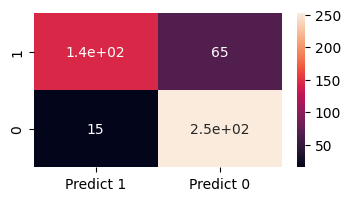

In [120]:
# Compute and print the confusion matrix
print("Confusion Matrix - XGB Classifier")
cm = confusion_matrix(y_test, y_predict_nn, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4,2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - XGB Classifier")
print(classification_report(y_test, y_predict_nn, labels=[1, 0]))


save_metrics_finalDf('Neural Network (HPT)', y_test, y_predict_nn)
save_model(best_model_nn, 'nn')


# Voting Classificator

In [121]:
estimators = estimators=[('LR', best_model_lr_2), ('KNN', best_model_knn_2), ('NB', model_nb), ('SVM', best_model_svm_2), ('RF', best_model_rf), ('BG', best_model_bgcl_2), ('ADA', best_model_adabc_2), ('XGB', best_model_xgbc_2), ('NN', best_model_nn)]

In [122]:
# Create a Voting Classifier (Soft Voting)


model_voting = VotingClassifier(estimators, voting='soft')
# Fit and evaluate the model
model_voting.fit(X_train, y_train)
accuracy_soft = model_voting.score(X_test, y_test)
print(f'Accuracy (Soft Voting): {accuracy_soft}')

# Make predictions on the test set
y_predict_voting_cl = model_voting.predict(X_test)

/Users/tomas/Documents/Tese/Predictive-models-Parkinson/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy (Soft Voting): 0.930672268907563


In [123]:
table_clf_soft = predicted_vs_actual_table(model_voting, X_test, y_test)
print(table_clf_soft)

      Actual  Predicted_Probability  Predicted_Class
1298     0.0               0.183831              0.0
654      1.0               0.616480              1.0
572      1.0               0.549360              1.0
1132     0.0               0.290919              0.0
628      1.0               0.676552              1.0
...      ...                    ...              ...
581      1.0               0.768593              1.0
126      1.0               0.900462              1.0
478      1.0               0.679038              1.0
985      0.0               0.148380              0.0
589      1.0               0.862765              1.0

[476 rows x 3 columns]


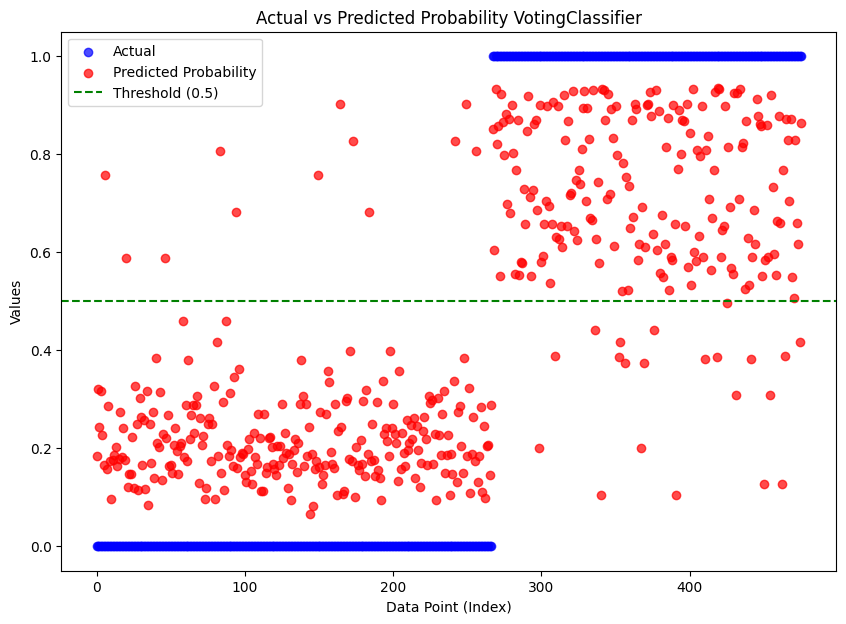

In [124]:
predicted_vs_actual_plot(table_clf_soft)

Confusion Matrix - Voting Classifier
Classification Report - Voting Classifier
              precision    recall  f1-score   support

           1       0.94      0.90      0.92       209
           0       0.92      0.96      0.94       267

    accuracy                           0.93       476
   macro avg       0.93      0.93      0.93       476
weighted avg       0.93      0.93      0.93       476



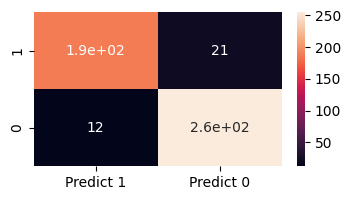

In [125]:
# Compute and print the confusion matrix
print("Confusion Matrix - Voting Classifier")
cm = confusion_matrix(y_test, y_predict_voting_cl, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4,2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Voting Classifier")
print(classification_report(y_test, y_predict_voting_cl, labels=[1, 0]))


save_metrics_finalDf('Voting Classifier - soft', y_test, y_predict_voting_cl)
save_model(model_voting, 'voting')


# Final Results

In [126]:
(final_results_df)

,accuracy,precision,recall,f1-score
Logistic Regression (HPT),0.71,0.72,0.71,0.70
KNN (HPT),0.91,0.91,0.91,0.91
NB,0.62,0.62,0.62,0.62
SVM (HPT),0.90,0.90,0.90,0.90
Random Forest (HPT),0.89,0.90,0.89,0.89
Bagging (HPT),0.92,0.92,0.92,0.92
AdaBoost (HPT),0.79,0.80,0.79,0.79
XGBoost (HPT),0.95,0.95,0.95,0.95
Neural Network (HPT),0.83,0.84,0.83,0.83
Voting Classifier - soft,0.93,0.93,0.93,0.93


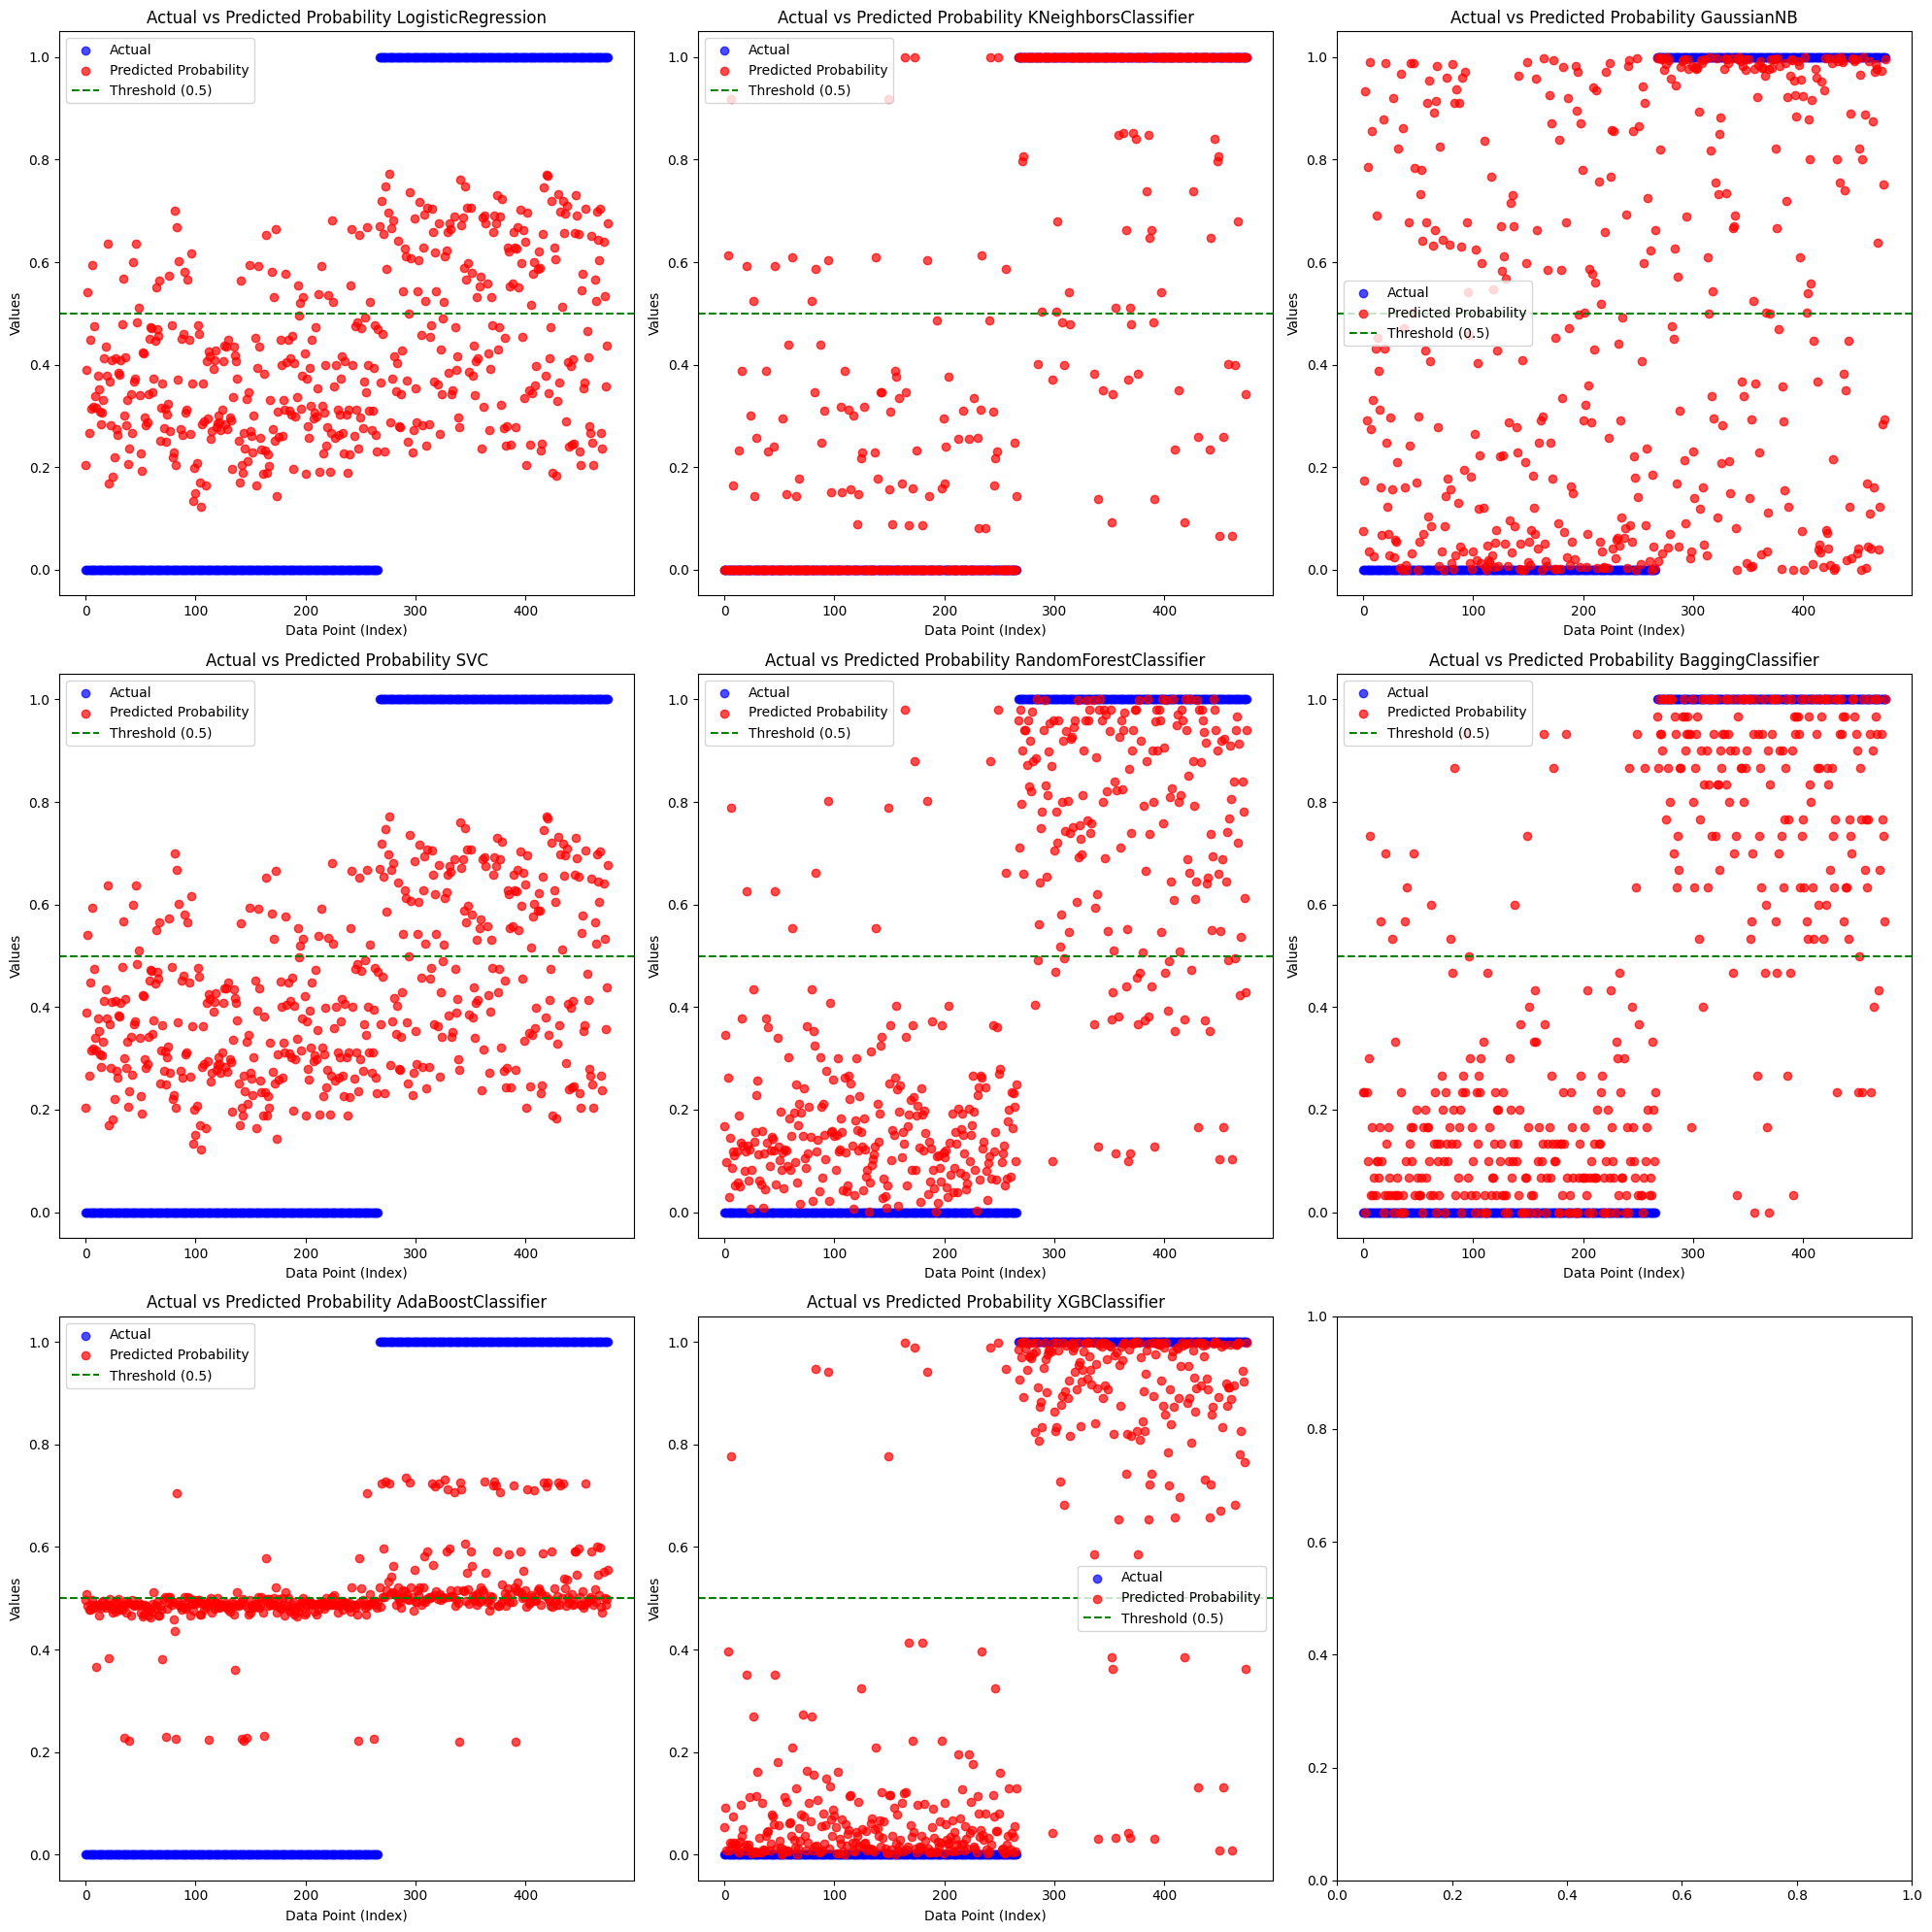

In [127]:

def PVASubplot(comparison_df, ax):
    # Sort the DataFrame by the 'Actual' column
    model_name = comparison_df.Name
    sorted_df = comparison_df.sort_values(by='Actual')

    # Scatter plot of Actual vs Predicted Probability
    ax.scatter(range(len(sorted_df)), sorted_df['Actual'], label='Actual', color='blue', alpha=0.7)
    ax.scatter(range(len(sorted_df)), sorted_df['Predicted_Probability'], label='Predicted Probability', color='red', alpha=0.7)

    # Draw a horizontal line at y=0.5
    ax.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

    ax.set_xlabel('Data Point (Index)')
    ax.set_ylabel('Values')
    ax.set_title('Actual vs Predicted Probability ' + model_name)
    ax.legend()


all_models_df = [table_lr_2, table_knn_2, table_nb, table_svm_2, table_rf, table_bgcl_2, table_adabc_2, table_xgbc_2]

rows = 3
cols = 3

# Create a subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))

for i in range(len(all_models_df)):
    PVASubplot(all_models_df[i], axes[i//cols][i%rows])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
